# __Tutorial 4: Flow computations (steady state)__

In this tutorial, we will focus on finding the solution to the __Darcy problem__, considering a fractured rock with impervious rock matrix.

At the end of this tutorial you will be able to:
* Create boundary conditions
* Solving a system
* Vizualisation of the system
* Access to the solution variables

Prerequisites
:
* Creation of a DFN ([Tuto2](https://gitlab.com/fractorylab/dfnlab/-/blob/master/Tutorials/Tuto2_Generation_DFN_stochastic.ipynb))
* Generation of a mesh ([Tuto3](https://gitlab.com/fractorylab/dfnlab/-/blob/master/Tutorials/Tuto3_Meshing.ipynb))
* Generation of hydraulic properties

### Creating boundary conditions

The boundary conditions are implemented in the module __DFNBoundaryCondition__.
<br>
For each _System_ border and _Well_, we can apply a boundary conditions.
<br>
Available boundary conditions are __Dirichlet__ and __Neumann__ with __fixed value__ on the object (border/well ...).
<br> Non constant boundary conditions are under development.

#### Permeameter boundary conditions

We first need a _DFN_. If you are not familiar with this part, you can refer to [Tuto2](https://gitlab.com/fractorylab/dfnlab/tree/master/Tutorials/Tuto2_DFNGenerator.ipynb).

In [1]:
import dfnlab.DFNIO as dfn_io
import dfnlab.DFNBasis as dfnB
import dfnlab.DFNGenerator as dfn_gen
import os 

In [2]:
display = True

In [3]:
system = dfnB.System()
system.buildParallelepiped([0, 0, 0], 50.)
fnet = dfnB.DFN(system)
generator = dfn_gen.PoissonGenerator(fnet,1001) #seed=1001
generator.setSizesPowerlaw(3.,2,50)
generator.setPositionsUniform()
generator.setOrientationsUniform()
generator.setStopDensity(0.5)
generator.generate()
fnet.computeIntersections()

The first example create a fixed charge at border 0 and 1, the border are noticed as
* 0 : -x face
* 1 : x face
* 2 : -y face
* 3 : y face
* 4 : -z face
* 5 : z face

In [4]:
import dfnlab.DFNBoundaryCondition as dfnBC

boundaries = dfnBC.DomainBoundaryCondition()

# Dirichlet boundaries
boundaries.setFixedPressure(fnet,0,10)
boundaries.setFixedPressure(fnet,1,0)

# Neuman boundaries
boundaries.setFixedFlux(fnet,2,0)
boundaries.setFixedFlux(fnet,3,0)
boundaries.setFixedFlux(fnet,4,0)
boundaries.setFixedFlux(fnet,5,0) 

The previous lines can be reduced to one, the second argument is the charge difference between boundaries, the third is the direction
* 1 : x direction
* 2 : y direction
* 3 : z direction

In [5]:
boundaries.setPermeameterCondition(fnet,10,1)

#### Wells boundary conditions

It is also possible to add wells with fixed pressure inside the DFN though:

In [6]:
epsilon = 2
system_size = 20

well1= dfnB.Well1D([ + epsilon, + epsilon, -system_size*0.45], [+epsilon, +epsilon, system_size*0.45])    
well2= dfnB.Well1D([- epsilon, - epsilon, -system_size*0.45], [-epsilon, - epsilon, system_size*0.45])    

We apply a fixed charge 10 on the first well and -10 and well2, this mimic a doublet pumping

In [7]:
boundaries.setWellInBC(fnet, 10,well1)
boundaries.setWellInBC(fnet, -10,well2)

## Example 1: Permeameter problem

We first need a _DFN_. If you are not familiar with this part, you can refer to [Tuto2](https://gitlab.com/fractorylab/dfnlab/tree/master/Tutorials/Tuto2_DFNGenerator.ipynb).
<br>
Then we need to get the backbone from this _DFN_. The backbone is composed of connected cluster linked to boundary conditions, removing dead ends. It corresponds to the structure carrying flow.
<br>
Then, we need to mesh the backbone. If you are not familiar with this part, you can refer to [Tuto3](https://gitlab.com/fractorylab/dfnlab/tree/master/Tutorials/Tuto3_Meshing.ipynb).

4366
MMG_creationOfIntersections
Increase intersection size
MMG_computeIntersectionsOnIntersections
parallel research 
Generation of edges 
0 intersections empty
Jarvis 
check the edges are Delaunay - preparation of angles 
check the edges are Delaunay - criteria 1 and 2 
0 intersections empty
2065 Fractures meshed  OK 
0 intersections are deleted not well defined after mesh 


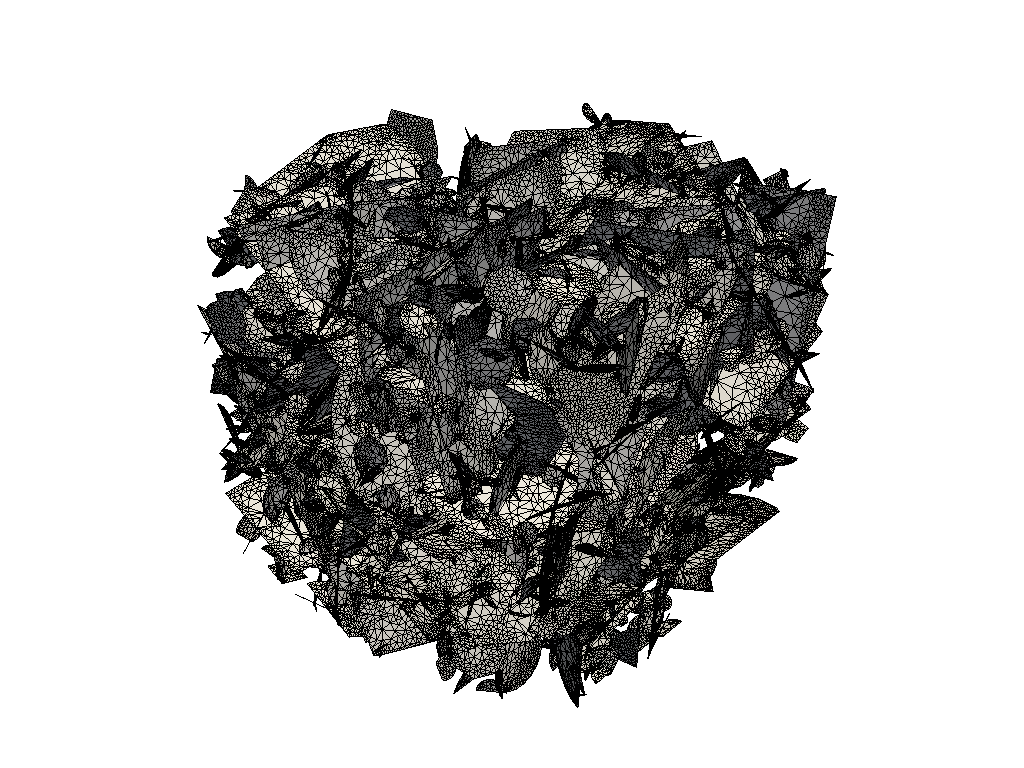

In [8]:
import dfnlab.DFNBasis as dfnB
import dfnlab.DFNGenerator as dfn_gen
import dfnlab.DFNGraph as dfnGr
import dfnlab.DFNBoundaryCondition as dfnBC
import dfnlab.DFNHydro as dfn_hydro
import dfnlab.DFNMesh as dfn_mesh
import dfnlab.DFNAnalysis as dfnA
import dfnlab.DFNIO as dfn_io
import pyvista as pv

# Generate DFN
system = dfnB.System()
system.buildParallelepiped([0, 0, 0], 50.)
fnet = dfnB.DFN(system)
generator = dfn_gen.PoissonGenerator(fnet,1001) #seed=1001
generator.setSizesPowerlaw(3.,2,50)
generator.setPositionsUniform()
generator.setOrientationsUniform()
generator.setStopDensity(0.5)
generator.generate()
fnet.computeIntersections()

# Creation of the boundary conditions 
boundaries = dfnBC.DomainBoundaryCondition()
boundaries.setPermeameterCondition(fnet,10,1)

# Set hydraulic properties
hydro = dfn_hydro.HydraulicProperties(fnet)
hydro.setConstant(1)

# Analysis of the DFN to find the backbone
analyzer = dfnA.DFNGraphAnalyzer(fnet,hydro,boundaries)
analyzer.computeGraph()
analyzer.computeBackboneGraph()
dfn_backbone = analyzer.getGraphDFN(backbone=True)

# Creation of the mesh
mesh = dfn_mesh.DFNMesh(dfn_backbone) 

mesh.setCaracteristicLength(10) 

mesh.setResolutionIntersection(4)
mesh.setResolutionGeometry(2)

mesh.setMinimumEdgeLength(10) 
mesh.setMaximumEdgeLength(0.5) 

mesh.setGradation(1.25)  
mesh.generateMesh()  
# Visualize
if display:
    path = os.getcwd()
    pathFolder = os.getcwd()+"/Tmp"
    if not os.path.isdir(pathFolder) :
        os.mkdir(pathFolder)

    dfn_io.write_mesh_file(mesh, pathFolder+"/Mesh_Current.vtp")
    visu = pv.read(pathFolder+"/Mesh_Current.vtp")
    p = pv.Plotter(notebook=True)
    p.set_background('white')
    p.add_mesh(visu, show_edges=True, color='white')
    p.show(auto_close=False, use_panel=False)

### Solving flow

Once the mesh is generated, we solve the __Darcy problem__.
<br>
The arguement given are the mesh, boundary conditions, and hydraulic properties (transmissivities). If hydraulic properties were applied in the mesh before, newproperties are considered. If a boundary conditions was applied, then the first one is kept. 


In [9]:
import dfnlab.DFNFlow as dfn_solver

flow = dfn_solver.solveDarcyProblem(mesh,boundaries,hydro)

Building of the linear system 
Time: to build the system: 6.95619 seconds. 
Taking account of the boundary conditions
Linear System solving
Time: to reconstruct the velocities: 8.12907 seconds. 


The method return a _DFNFlow_ object, containing the transmissivities, heads, velocities and all variables to consider the flow. Also, flow indicators are available attached to this object.
<br>
Example of accesses are given below. It returns a list of all values, in the same order than the list of triangles. Other accesses are available (see the doc).

In [10]:
flow.head() # Acess to hydraulic heads
flow.velocity() # Access to velocities
flow.flow() # Access to total discharge

You can also save these quantities for visualization

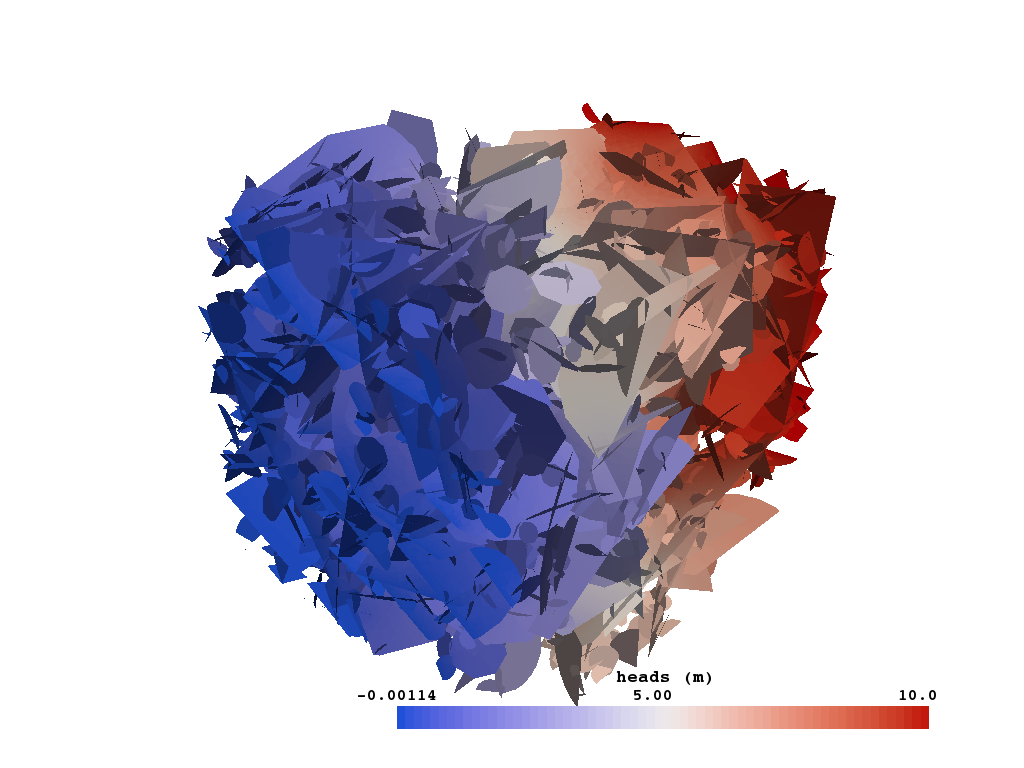

In [11]:
if display:
    
    import pyvista as pv

    Aw = dfn_io.DFNIO_Object(mesh)
    Aw.appendDataOnMesh(flow.head(),"heads (m)")
    Aw.appendDataOnMesh(flow.velocity(),"velocities (m/s)")
    Aw.appendDataOnMesh(flow.flow(),"total discharge (m^3/s)")
    Aw.writeVTKOnMesh(pathFolder+"/PermeameterTest.vtp",True)


    visu = pv.read(pathFolder+"/PermeameterTest.vtp")
    p = pv.Plotter(notebook=True)
    argss = dict(color='black', n_labels = 3, title_font_size = 14, label_font_size=12)
    p.set_background('white')
    p.add_mesh(visu,show_edges=False,scalars='heads (m)', cmap='coolwarm', lighting=True, show_scalar_bar=True, scalar_bar_args=argss)
    p.show(auto_close=False, use_panel=False)

### Get Indicators values

The _DFNFlow_ object gets also some indicators, the logic is the same for every indicators
There are 2 possibilities
* A global value for the whole DFN
* A particular value for one object (Fracture, Intersection, Wells ...)

We show here some examples, for detailed explanations, please refer to the documentation

#### Global values

In [12]:
inputFlow = flow.getIndicatorsValue(dfn_solver.IndicatorsEnum.inputInFractures)
print("Input flow: {}".format(inputFlow))

outputFlow = flow.getIndicatorsValue(dfn_solver.IndicatorsEnum.outputInFractures)
print("Output flow: {}".format(outputFlow))

print('Relative difference between input and output: '+ ( (inputFlow + outputFlow) / (outputFlow+ 1e-18)).__str__())

totalFluxInSystem = flow.getIndicatorsValue(dfn_solver.IndicatorsEnum.totalFluxInSystem)
print("Total flux is: {}".format(totalFluxInSystem))

k = flow.getIndicatorsValue(dfn_solver.IndicatorsEnum.hydraulicConductivity)
print("Equivalent Hydraulic conductivity is: {}".format(k))

Input flow: 514.726817421305
Output flow: -514.7268174213181
Relative difference between input and output: 2.539985463256799e-14
Total flux is: 37.965623475189965
Equivalent Hydraulic conductivity is: 0.07593124695037992
